In [1]:
# Start off with a demo of fitting just the time GP
import pandas as pd
from tgp.experiments import get_dataset
from tgp.gp_predictor import GPPredictor
from tgp.matern_kernels import MaternKernel32
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = get_dataset()
df = df[df['start_date'].dt.year >= 2016]

In [3]:
df.head()

,ID1,ID2,ID_T,round,score,start_date,tournament_rank,surface,winner,loser,...,FAST_2,A1S_2,A2S_2,RPW_1,RPWOF_1,RPW_2,RPWOF_2,MT,round_number,year
10521,7043,25708,12783,4,6-1 6-1,2016-01-04,2,hard,Jeremy Chardy,Mubarak Shannan Zayid,...,NaN,NaN,NaN,32.0,54.0,9.0,34.0,12/30/99 00:46:22,4,2016
10522,13799,11701,12783,4,6-2 6-4,2016-01-04,2,hard,Andrey Kuznetsov,Marsel Ilhan,...,NaN,NaN,NaN,26.0,51.0,17.0,55.0,12/30/99 01:04:36,4,2016
10523,6081,18524,12783,4,5-7 6-1 7-5,2016-01-04,2,hard,Robin Haase,Aslan Karatsev,...,NaN,NaN,NaN,47.0,108.0,39.0,102.0,12/30/99 02:19:06,4,2016
10524,2379,468,12783,4,3-6 7-6(4) 7-5,2016-01-04,2,hard,Daniel Munoz-De La Nava,Feliciano Lopez,...,NaN,NaN,NaN,36.0,110.0,30.0,102.0,12/30/99 02:25:22,4,2016
10525,5992,4003,12783,4,6-2 6-2,2016-01-04,2,hard,Novak Djokovic,Dustin Brown,...,NaN,NaN,NaN,29.0,55.0,10.0,40.0,12/30/99 00:51:15,4,2016


In [4]:
# Instantiate the kernel with the best values (see paper)
kernel = MaternKernel32(np.array([5.29]), 0.882)

In [5]:
# Instantiate the predictor
predictor = GPPredictor(kernel)

In [6]:
# The last thing we need is the days since start.
days_since_start = (df['start_date'] - df['start_date'].min()).dt.days.values

# Now we can fit the model:
predictor.fit(df['winner'].values, df['loser'].values, days_since_start)

In [7]:
# OK, we've fit the model. Let's plot some players:
players = ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic', 'Andy Murray']
days_to_predict = np.linspace(days_since_start.min(), days_since_start.max(), 20)

predictions = list()

for cur_player in players:
    for cur_day in days_to_predict:
        cur_mean, cur_sd = predictor.predict(cur_player, cur_day)
        
        predictions.append({'player': cur_player, 'mean': cur_mean, 'sd': cur_sd, 
                            'days_since_start': cur_day})
        
predictions = pd.DataFrame(predictions)

In [8]:
predictions['date'] = df['start_date'].min() + pd.to_timedelta(predictions['days_since_start'], unit='days')
predictions = predictions.set_index('player')

Text(0.5, 1.0, 'Player ratings over time')

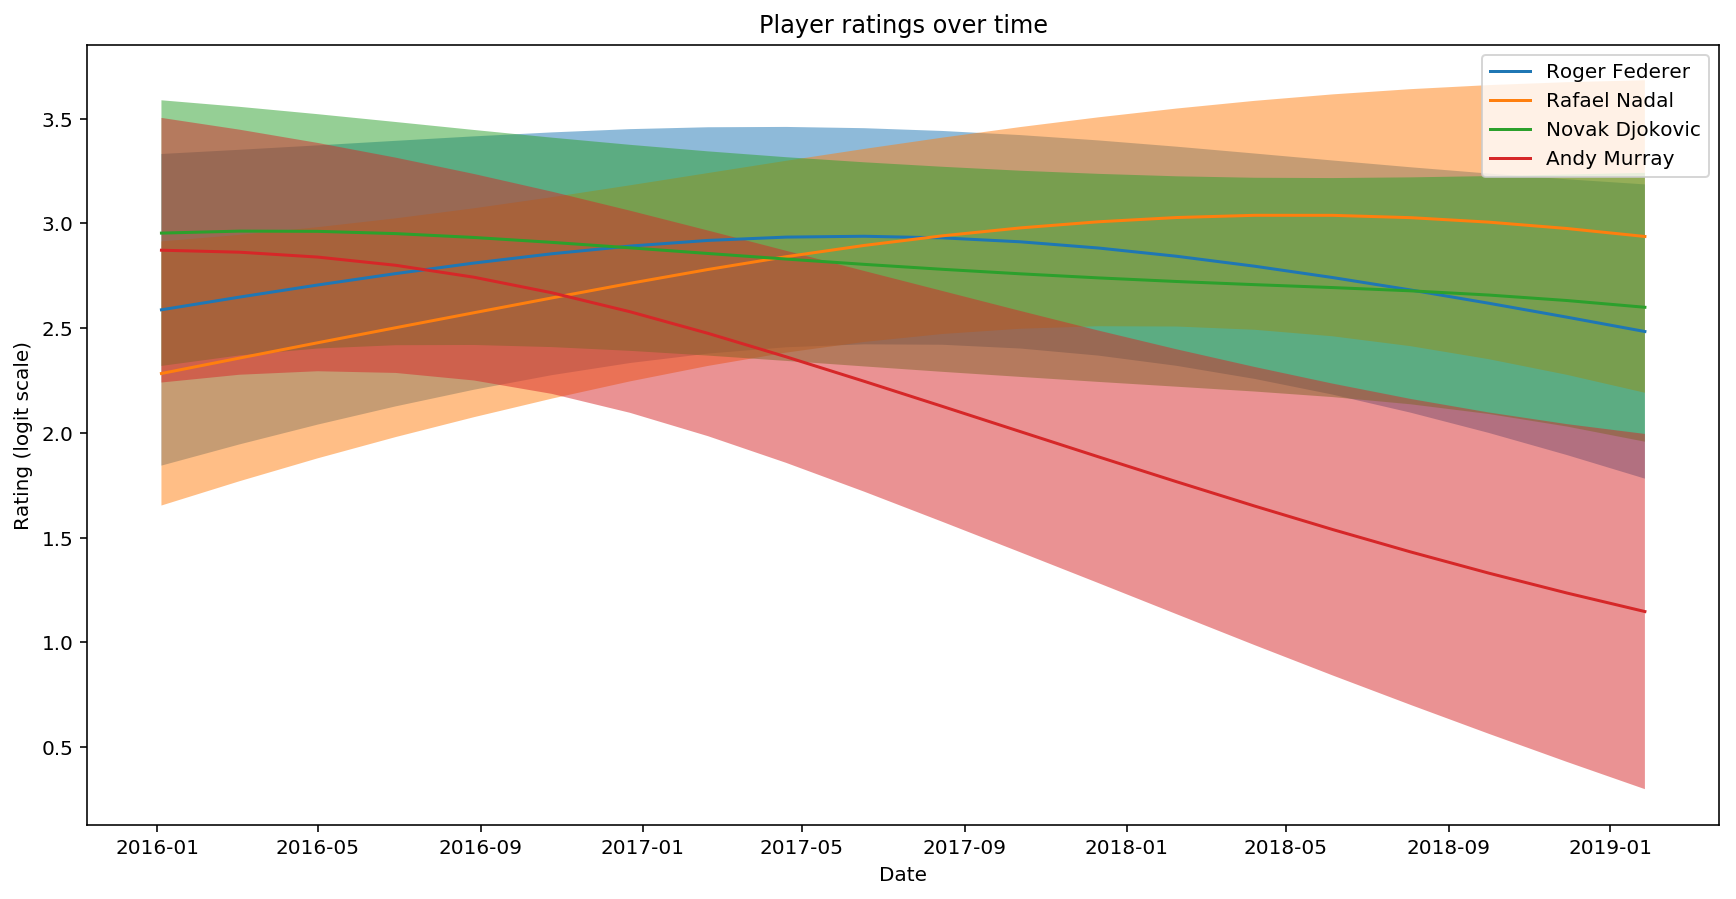

In [10]:
f, ax = plt.subplots(1, 1)

for cur_player in players:

    cur_data = predictions.loc[cur_player]
    ax.plot(cur_data['date'], cur_data['mean'], label=cur_player)
    ax.fill_between(cur_data['date'].values, cur_data['mean'] - 2 * cur_data['sd'], 
                    cur_data['mean'] + 2 * cur_data['sd'],
                    alpha=0.5)
    
plt.legend()
f.set_size_inches(12, 6)
f.tight_layout()
ax.set_xlabel('Date')
ax.set_ylabel('Rating (logit scale)')
ax.set_title('Player ratings over time')

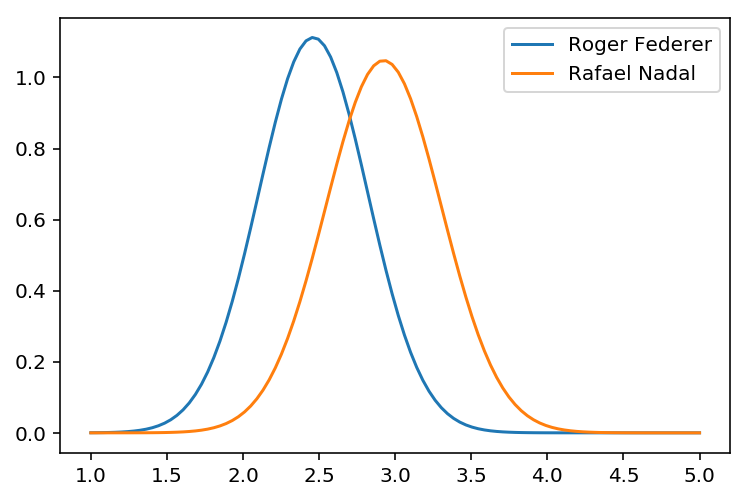

In [11]:
from datetime import datetime
from scipy.stats import norm
from scipy.special import expit

# Predict a match:
p1 = 'Roger Federer'
p2 = 'Rafael Nadal'
date = datetime(2019, 2, 15)

days_since_start = (date - df['start_date'].min()).days

p1_mean, p1_sd = predictor.predict(p1, days_since_start)
p2_mean, p2_sd = predictor.predict(p2, days_since_start)

# Plot the PDF for both
x_range = np.linspace(1, 5, 100)
p1_y = norm.pdf(x_range, p1_mean, p1_sd)
p2_y = norm.pdf(x_range, p2_mean, p2_sd)

plt.plot(x_range, p1_y, label=f'{p1}')
plt.plot(x_range, p2_y, label=f'{p2}')

plt.legend()

In [12]:
# Sample from these to obtain predictions
n_draws = 100000
p1_draws = norm.rvs(p1_mean, p1_sd, size=n_draws)
p2_draws = norm.rvs(p2_mean, p2_sd, size=n_draws)
diffs = p1_draws - p2_draws

predictions = expit(diffs)
mean_pred = np.mean(predictions)

print(f'Probability that {p1} wins is estimated to be {mean_pred}.')

Probability that Roger Federer wins is estimated to be 0.39296602568845485.
